In [ ]:
! pip install transformers

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pickle
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open ('/content/drive/Shareddrives/FBI_Intern/label_data.pkl', 'rb') as f:
    df = pickle.load(f)

In [ ]:
df

,name,summary,class1,integer_labels
0,誠品信義旗艦店,誠品信義店開幕於2006年1月1日，位於信義計畫區菁華區位，連通市政府捷運站，具有絕佳立地條...,百貨,14
1,誠品信義旗艦店,... 文化店; 誠品生活竹北遠百店; 誠品酒窖南西店-Nan-Xi; 誠品生活時光–內湖瑞...,百貨,14
2,誠品信義旗艦店,2021年11月15日 — 2006年開幕的誠品信義旗艦店擁有八層樓的廣大空間，從低樓層的美...,百貨,14
3,誠品信義旗艦店,即使香港已經開設誠品書店，不少遊客到臺灣時還是會到當地的誠品潮聖，不但因為店面更大貨物更齊全...,百貨,14
4,誠品信義旗艦店,誠品以「人文、藝術、創意、生活」為核心價值，由推廣閱讀出發，致力在書與非書之間複合創新，發展...,百貨,14
...,...,...,...,...
12738,魚中魚,"魚中魚的定位就是要做全國最大的全方位水族寵物用品賣場,以寬廣、明亮、整潔的大坪數購物空間,給...",其他,5
12739,魚中魚,"寵物線上購物平臺,毛孩線上購物,商品包含各大品牌寵物飼料:(皇家、希爾思),處方飼料、寵物百...",其他,5
12740,魚中魚,2022年4月25日 — 寵物水族商品一應俱全指定犬貓飼料買一送一國際品牌特惠下殺68折起....,其他,5
12741,魚中魚,魚中魚貓狗水族-北屯店. 電話：04-22478866. 地址：臺中市北屯區文心路四段319...,其他,5


In [ ]:
epoches = 10
batch_size = 16
test_size = 0.3
#設置為 1，生成一組訓練/驗證拆分。
n_splits = 1
# 檢查是否有 GPU 支援
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#低於多少叫未知
THRESHOLD = 0.5
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# 定義自定義數據集類
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
      self.texts = texts
      self.labels = labels
      self.tokenizer = tokenizer
      self.max_length = max_length

  def __len__(self):
      return len(self.texts)

  def __getitem__(self, idx):
      text = self.texts[idx]
      inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
      input_ids = inputs['input_ids'].squeeze()
      attention_mask = inputs['attention_mask'].squeeze()
      label = torch.tensor(self.labels[idx], dtype=torch.long)
      return input_ids, attention_mask, label

In [ ]:
# 載入 Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 切分數據集為訓練、驗證和測試集
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df['summary'].tolist(),
                                          df['integer_labels'].tolist(),
                                          stratify=df['integer_labels'],
                                          test_size=test_size)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_val_texts,
                                    train_val_labels,
                                    stratify=train_val_labels,
                                    test_size=test_size)

# 創建數據集
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
# 計算每個類的權重
  #計算每個類別的數量
class_counts = np.bincount(train_labels)
  #計算每個類別的倒數:
  #對每個類別的計數取倒數。這樣做的原因是，如果一個類別在數據集中的出現次數較少，
  #那麼希望在訓練過程中對其進行更頻繁的抽樣。取倒數可以實現這一目的：出現次數少的類別將具有更高的權重。
class_weights = 1. / class_counts
# 轉換為 PyTorch 張量並移到正確的設備上
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# 創建 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights))

# 創建數據加載器
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
# 創建模型
num_labels = len(df['integer_labels'].unique())
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=num_labels)
model.to(device)
# 定義損失函數並使用類別權重
loss_function = torch.nn.CrossEntropyLoss(weight=weights)
# 定義優化器
optimizer = AdamW(model.parameters(), lr=1e-5)
# 動態學習率調整（ReduceLROnPlateau）
# 如果驗證損失不再下降，您可以降低學習率。這可以通過
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 初始化歷史記錄
history = {
    'train_loss': [],
    'train_accuracy': [],
    'valid_loss': [],
    'valid_accuracy': []
}

# 訓練模型
for epoch in range(epoches):
  model.train()
  train_loss = 0
  train_preds = []
  train_true_labels = []
  # 訓練循環
  for batch in tqdm(train_loader):
      input_ids, attention_mask, labels = [item.to(device) for item in batch]
      outputs = model(input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs.logits, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      train_loss += loss.item() * len(labels)
      train_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
      train_true_labels.extend(labels.cpu().numpy())
  train_loss /= len(train_loader.dataset)
  train_accuracy = accuracy_score(train_true_labels, train_preds)
  history['train_loss'].append(train_loss)
  history['train_accuracy'].append(train_accuracy)

  # 驗證循環
  model.eval()
  valid_loss = 0
  valid_preds = []
  valid_true_labels = []
  with torch.no_grad():
      for batch in tqdm(val_loader):
          input_ids, attention_mask, labels = [item.to(device) for item in batch]
          outputs = model(input_ids, attention_mask=attention_mask)
          loss = loss_function(outputs.logits, labels)
          valid_loss += loss.item() * len(labels)
          valid_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
          valid_true_labels.extend(labels.cpu().numpy())
  valid_loss /= len(val_loader.dataset)
  valid_accuracy = accuracy_score(valid_true_labels, valid_preds)
  history['valid_loss'].append(valid_loss)
  history['valid_accuracy'].append(valid_accuracy)
  scheduler.step(valid_loss)
# 打印歷史記錄
print(history)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

{'train_loss': [0.009569974317845875, 0.008771734475126818, 0.008008448625156407, 0.008025313290099275, 0.006551732526011615, 0.007039132702238307, 0.006650869811046492, 0.005586764613519928, 0.00604242639939525, 0.005758496986584259], 'train_accuracy': [0.05, 0.2, 0.45, 0.3, 0.45, 0.45, 0.45, 0.65, 0.6, 0.5], 'valid_loss': [3.1028793827518, 3.1037173656691186, 3.1053130323508844, 3.108469924148248, 3.1073081482149183, 3.1049400876792297, 3.1013317037040435, 3.0963376504098603, 3.091031399027706, 3.0871914443640356], 'valid_accuracy': [0.060832025117739406, 0.0521978021978022, 0.05102040816326531, 0.046703296703296704, 0.04277864992150707, 0.045133437990580845, 0.04552590266875981, 0.046703296703296704, 0.046703296703296704, 0.04552590266875981]}


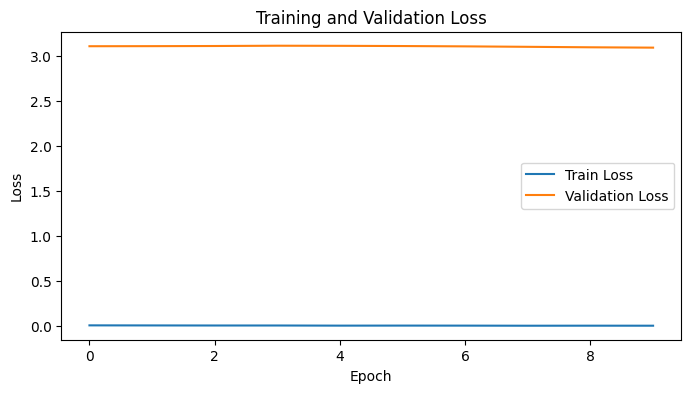

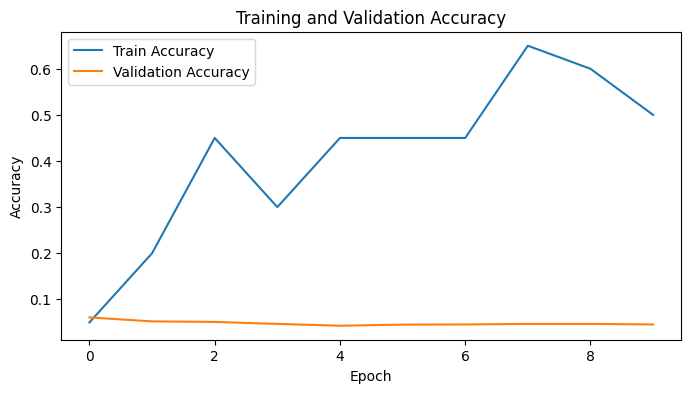

In [ ]:
import matplotlib.pyplot as plt

# 提取歷史數據
train_loss = history['train_loss']
valid_loss = history['valid_loss']
train_accuracy = history['train_accuracy']
valid_accuracy = history['valid_accuracy']

# 繪製損失
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製精確度
plt.figure(figsize=(8, 4))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
with open('/content/drive/Shareddrives/FBI_Intern/label_encoding_mapping.pkl', 'rb') as f:
    label_encoding_mapping = pickle.load(f)
label_encoding_mapping['class1_encoded'] = label_encoding_mapping['class1_encoded'].astype(str)

In [ ]:
all_labels = []
all_preds = []

# 驗證循環
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)

In [ ]:
# 生成類別報告
class_report = classification_report(all_labels, all_preds, output_dict=True)

# 轉換為 DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# 將類別報告與標籤編碼映射合併
merged_report = class_report_df.reset_index().rename(columns={"index": "class1_encoded"}).merge(label_encoding_mapping, on="class1_encoded")
merged_report = merged_report[['class1', 'precision', 'recall', 'f1-score', 'support']]
# 顯示合併後的報告
merged_report

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class1,precision,recall,f1-score,support
0,3C,0.000000,0.000000,0.000000,112.0
1,一般消費,0.000000,0.000000,0.000000,9.0
2,一般購物,0.000000,0.000000,0.000000,129.0
3,交通汽修,0.000000,0.000000,0.000000,343.0
4,保險,0.049785,0.488263,0.090356,213.0
5,其他,0.000000,0.000000,0.000000,186.0
6,加油,0.028302,0.111111,0.045113,81.0
7,外送平台,0.000000,0.000000,0.000000,52.0
8,家居修繕,0.000000,0.000000,0.000000,41.0
9,捐款,0.000000,0.000000,0.000000,48.0


# 保存訓練好的模型

In [ ]:
# 使用 PyTorch 的方式保存模型
torch.save(model.state_dict(), 'hugo_base.pt')

In [ ]:
# 使用 PyTorch 的方式載入模型
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=num_labels)
model.load_state_dict(torch.load('hugo_base.pt'))
model.to(device)  # 如果使用 GPU

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,